In [9]:
# Load the final processed dataset
import pandas as pd
FIGURE_PATH = "../Figures/"

DATA_PATH = "../Dataset/neo_processed.csv"
df_processed = pd.read_csv(DATA_PATH)
print("Loaded shape:", df_processed.shape)
df_processed.head()

Loaded shape: (39709, 45)


,sats,H,diameter,albedo,rot_per,epoch,e,a,q,i,...,rms,diameter_estimated_flag,epoch_cal,class,hazardous_label,risk_score,perihelion_ratio,eccentric_energy,uncertainty_total,observation_span_years
0,0.0,10.39,16.840000,0.250,5.270,2461000.5,0.222836,1.458121,1.133199,10.828467,...,0.29796,0.0,2025-11-21.0000000,AMO,0,0.648766,0.777164,0.072404,1.179775e-06,127.621918
1,0.0,15.59,2.736306,0.137,5.801,2461000.5,0.546596,2.636590,1.195441,11.573111,...,0.40589,1.0,2025-11-21.0000000,AMO,0,0.318619,0.453404,0.787726,4.594650e-06,113.558904
2,0.0,13.81,4.200000,0.310,28.410,2461000.5,0.571170,2.473629,1.060766,9.400060,...,0.25971,0.0,2025-11-21.0000000,AMO,0,0.908811,0.428830,0.806985,1.123263e-06,107.619178
3,0.0,9.18,37.675000,0.238,10.297,2461000.5,0.533213,2.664969,1.243972,26.680736,...,0.31447,0.0,2025-11-21.0000000,AMO,0,0.317274,0.466787,0.757694,4.382260e-07,101.046575
4,0.0,17.37,1.000000,0.137,4.400,2461000.5,0.434632,1.919831,1.085411,11.868823,...,0.40562,0.0,2025-11-21.0000000,AMO,0,0.533213,0.565368,0.362666,7.272382e-06,93.005479


In [10]:
# Preprocess: select features, scale, and separate label
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import os

# Ensure figure path exists
os.makedirs(FIGURE_PATH, exist_ok=True)

# Identify label and feature columns
label_col = 'hazardous_label'
assert label_col in df_processed.columns, f"Missing column: {label_col}"

# Separate X, y
y = df_processed[label_col].astype(int)
X = df_processed.drop(columns=[label_col])

# Select numeric features only (for clustering)
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X_num = X[num_cols].copy()

# Basic preprocessing: impute missing values and scale
preprocess = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
])

X_pre = preprocess.fit_transform(X_num)
print('Preprocessed shape:', X_pre.shape)

# Dimensionality reduction for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_pre)
print('Explained variance (2D PCA):', pca.explained_variance_ratio_.sum())

Preprocessed shape: (39709, 42)
Explained variance (2D PCA): 0.31421671460176853


In [11]:
# Clustering: KMeans and GMM across candidate cluster counts
results = []
candidate_k = [2, 3, 4, 5, 6]  # hazardous likely binary, but try a few
for k in candidate_k:
    # KMeans
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km_labels = km.fit_predict(X_pre)
    ari_km = adjusted_rand_score(y, km_labels)
    nmi_km = normalized_mutual_info_score(y, km_labels)
    results.append({'model':'KMeans','k':k,'ARI':ari_km,'NMI':nmi_km})
    
    # Gaussian Mixture
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm_labels = gmm.fit_predict(X_pre)
    ari_gmm = adjusted_rand_score(y, gmm_labels)
    nmi_gmm = normalized_mutual_info_score(y, gmm_labels)
    results.append({'model':'GMM','k':k,'ARI':ari_gmm,'NMI':nmi_gmm})

import pandas as pd
res_df = pd.DataFrame(results).sort_values(['ARI','NMI'], ascending=False)
print('Top results by ARI:')
print(res_df.head(10))

best = res_df.iloc[0]
best_model_name = best['model']
best_k = int(best['k'])
print(f"Best model: {best_model_name} with k={best_k}, ARI={best['ARI']:.4f}, NMI={best['NMI']:.4f}")

# Fit best model and get labels
if best_model_name == 'KMeans':
    best_model = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
    best_labels = best_model.fit_predict(X_pre)
else:
    best_model = GaussianMixture(n_components=best_k, covariance_type='full', random_state=42)
    best_labels = best_model.fit_predict(X_pre)

# Map cluster ids to match label for overlap (only when binary)
def maximize_overlap(true, cluster):
    # If more than 2 clusters, keep cluster ids; for k==2, optionally flip for better match
    if len(np.unique(cluster)) == 2:
        acc = (cluster == true).mean()
        acc_flipped = ((1-cluster) == true).mean()
        return cluster if acc >= acc_flipped else (1-cluster)
    return cluster

aligned_labels = maximize_overlap(y.values, best_labels)
overlap = (aligned_labels == y.values).mean()
print(f"Overlap with hazardous_label: {overlap:.4f}")

Top results by ARI:
    model  k       ARI       NMI
5     GMM  4  0.125003  0.047646
3     GMM  3  0.106738  0.088805
1     GMM  2  0.102351  0.020715
9     GMM  6  0.098389  0.083685
7     GMM  5  0.090760  0.086712
2  KMeans  3  0.024663  0.023570
4  KMeans  4  0.024532  0.023329
6  KMeans  5  0.021207  0.019381
8  KMeans  6  0.021204  0.019380
0  KMeans  2 -0.005018  0.013545
Best model: GMM with k=4, ARI=0.1250, NMI=0.0476
Overlap with hazardous_label: 0.0924
Overlap with hazardous_label: 0.0924


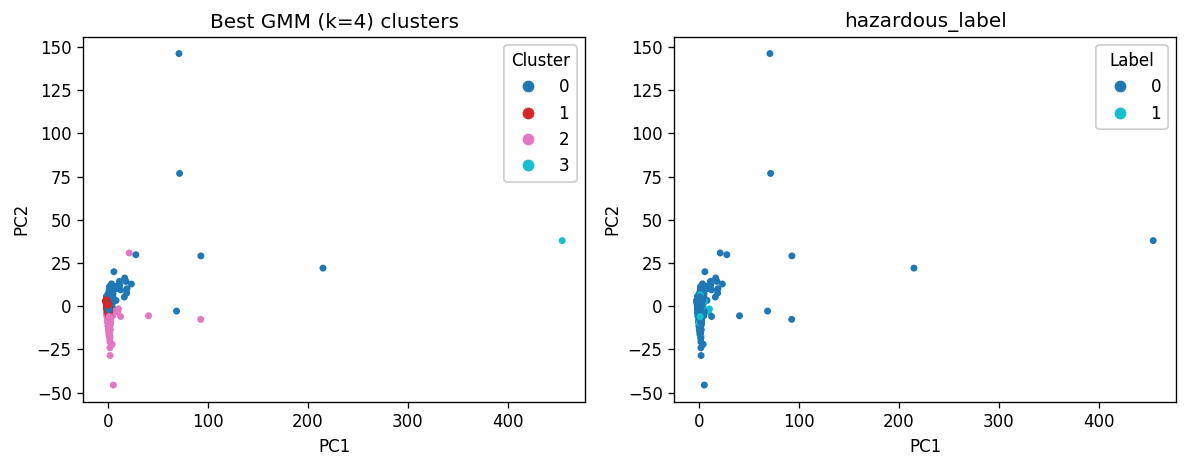

In [12]:
# Visualize PCA scatter colored by aligned cluster and label
fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=120)
scatter0 = ax[0].scatter(X_pca[:,0], X_pca[:,1], c=aligned_labels, cmap='tab10', s=10)
ax[0].set_title(f'Best {best_model_name} (k={best_k}) clusters')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
legend1 = ax[0].legend(*scatter0.legend_elements(), title="Cluster")
ax[0].add_artist(legend1)

scatter1 = ax[1].scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='tab10', s=10)
ax[1].set_title('hazardous_label')
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')
legend2 = ax[1].legend(*scatter1.legend_elements(), title="Label")
ax[1].add_artist(legend2)

plt.tight_layout()
plt.show()

In [ ]:
# Improved unsupervised: richer preprocessing and more clustering models
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN

# Build enhanced preprocessing pipeline on numeric features
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X_num = X[num_cols].copy()

enhanced_pre = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('quantile', QuantileTransformer(output_distribution='normal', random_state=42, n_quantiles=min(1000, max(10, X_num.shape[0])))),
    ('power', PowerTransformer(method='yeo-johnson', standardize=True)),
    ('var', VarianceThreshold(threshold=1e-4)),
    ('scale', StandardScaler()),
])

X_enh = enhanced_pre.fit_transform(X_num)
print('Enhanced preprocessed shape:', X_enh.shape)

# Try dimensionality reduction to whiten space for clustering
pca_wh = PCA(n_components=min(30, X_enh.shape[1]), whiten=True, random_state=42)
X_wh = pca_wh.fit_transform(X_enh)
print('PCA-whitened dims:', X_wh.shape[1], 'Explained:', pca_wh.explained_variance_ratio_.sum())

# Candidate models (focus on binary k=2 where applicable)
experiments = []

# KMeans k=2
experiments.append(('KMeans', KMeans(n_clusters=2, random_state=42, n_init='auto'), X_wh))
experiments.append(('KMeans_raw', KMeans(n_clusters=2, random_state=42, n_init='auto'), X_enh))

# SpectralClustering k=2 with different affinity
experiments.append(('Spectral-rbf', SpectralClustering(n_clusters=2, affinity='rbf', random_state=42), X_enh))
experiments.append(('Spectral-nearest', SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42, n_neighbors=15), X_enh))

# AgglomerativeClustering k=2 with linkage variants
experiments.append(('Agg-ward', AgglomerativeClustering(n_clusters=2, linkage='ward'), X_enh))
experiments.append(('Agg-complete', AgglomerativeClustering(n_clusters=2, linkage='complete'), X_enh))
experiments.append(('Agg-average', AgglomerativeClustering(n_clusters=2, linkage='average'), X_enh))

# DBSCAN sweeps (requires density separation; try on whitened)
for eps in [0.5, 0.8, 1.2, 1.6]:
    for min_samples in [5, 10, 20]:
        experiments.append((f'DBSCAN-e{eps}-m{min_samples}', DBSCAN(eps=eps, min_samples=min_samples), X_wh))

results2 = []
best_overlap = -1
best_desc = None
best_labels2 = None

def align_binary(true, pred):
    if len(np.unique(pred)) == 2 and set(np.unique(pred)) <= {0,1}:
        acc = (pred == true).mean()
        acc_flip = ((1-pred) == true).mean()
        return pred if acc >= acc_flip else (1-pred)
    # For labels not in {0,1}, map two most frequent to 0/1 if possible
    vals = np.unique(pred)
    if len(vals) == 2:
        mapping = {vals[0]:0, vals[1]:1}
        mapped = np.vectorize(mapping.get)(pred)
        return align_binary(true, mapped)
    return pred

for name, model, X_src in experiments:
    try:
        if hasattr(model, 'fit_predict'):
            labels = model.fit_predict(X_src)
        else:
            labels = model.fit(X_src).predict(X_src)
        labels_al = align_binary(y.values, labels)
        overlap = (labels_al == y.values).mean()
        ari = adjusted_rand_score(y, labels)
        nmi = normalized_mutual_info_score(y, labels)
        results2.append({'model':name, 'ARI':ari, 'NMI':nmi, 'overlap':overlap})
        if overlap > best_overlap:
            best_overlap = overlap
            best_desc = name
            best_labels2 = labels_al
    except Exception as e:
        results2.append({'model':name, 'ARI':np.nan, 'NMI':np.nan, 'overlap':np.nan, 'error':str(e)})

res2_df = pd.DataFrame(results2).sort_values(['overlap','ARI','NMI'], ascending=False)
print('Top models (by overlap):')
print(res2_df.head(10))
print(f'Best overlap: {best_overlap:.4f} via {best_desc}')

# If improvement found, update aligned_labels for downstream plots
if best_labels2 is not None:
    aligned_labels = best_labels2
else:
    print('No improved labels found; keeping previous aligned_labels')

Enhanced preprocessed shape: (39709, 42)
PCA-whitened dims: 30 Explained: 0.9991039233572675
